<p align="center">
  <img src="doc/Muhmmad Abdullah VLM Fine Tune.jpg" alt="Research Banner" width="600"/>
</p>

# Fine-Tuning CLIP with LoRA on Flickr30k

*By [Muhammad Abdullah](https://www.linkedin.com/in/muhammad-abdullah-ai-ml-developer/)*  
<i>July 06, 2025</i>

# Install required packages

In [1]:
!pip install transformers datasets torch torchvision pillow tqdm peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [5]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


# Set device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fine-tune the model

In [15]:
# Imports
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPModel, CLIPProcessor, Trainer, TrainingArguments
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Load and inspect the Flickr30k dataset
dataset = load_dataset("AnyModal/flickr30k")
print("Dataset structure:", dataset)
print("Sample train item:", dataset["train"][0])

# Step 2: Define a custom dataset class for Flickr30k
class Flickr30kDataset(Dataset):
    def __init__(self, dataset, processor, split="train"):
        self.dataset = dataset[split]
        self.processor = processor
        self.image_transforms = transforms.Compose([
            transforms.Resize((224, 224)),  # CLIP expects 224x224
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                               std=[0.26862954, 0.26130258, 0.27577711])
        ])
        # Check for caption field name
        sample_item = self.dataset[0]
        self.caption_field = "alt_text"  # Based on dataset structure
        if self.caption_field not in sample_item:
            raise KeyError(f"'alt_text' not found in dataset. Available fields: {list(sample_item.keys())}")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"].convert("RGB")  # Ensure RGB format
        # Access caption
        captions = item[self.caption_field]
        caption = captions[0] if isinstance(captions, list) else captions  # Handle list or single string

        # Preprocess image
        image = self.image_transforms(image)

        # Preprocess text
        text_inputs = self.processor.tokenizer(
            caption,
            padding="max_length",
            max_length=77,  # CLIP's max token length
            truncation=True,
            return_tensors="pt"
        )

        return {
            "pixel_values": image,
            "input_ids": text_inputs["input_ids"].squeeze(),
            "attention_mask": text_inputs["attention_mask"].squeeze()
        }

# Step 3: Load CLIP model and processor
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

# Step 4: Configure LoRA
lora_config = LoraConfig(
    r=16,  # Rank of LoRA adapters
    lora_alpha=32,  # Scaling factor
    target_modules=["q_proj", "v_proj", "k_proj", "out_proj", "fc1", "fc2"],  # Target attention and FFN layers
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"]  # Save classifier if any
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()  # Verify trainable parameters (~1-2% of total)

# Step 5: Create dataset and dataloader
train_dataset = Flickr30kDataset(dataset, processor, split="train")
val_dataset = Flickr30kDataset(dataset, processor, split="test")

# Step 6: Define training arguments
training_args = TrainingArguments(
    output_dir="./clip-lora-finetuned-flickr30k",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=1e-4,
    warmup_steps=500,
    gradient_accumulation_steps=4,  # Effective batch size = 8 * 4 = 32
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=2,
    load_best_model_at_end=True,
    fp16=True,
    logging_steps=100,
    remove_unused_columns=False,
    report_to="none"
)

# Step 7: Define a custom collate function
def collate_fn(batch):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    input_ids = torch.stack([item["input_ids"] for item in batch])
    attention_mask = torch.stack([item["attention_mask"] for item in batch])
    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "return_loss": True
    }

# Step 8: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn
)

# Step 9: Fine-tune the model
trainer.train()

# Step 10: Save the fine-tuned model and LoRA adapters
model.save_pretrained("./clip-lora-finetuned-flickr30k")
processor.save_pretrained("./clip-lora-finetuned-flickr30k")

# Step 11: Evaluate a sample
def evaluate_sample(model, processor, dataset, idx=0):
    model.eval()
    item = dataset[idx]
    image = item["pixel_values"].unsqueeze(0).to(device)
    caption = dataset.dataset[idx][dataset.caption_field][0] if isinstance(dataset.dataset[idx][dataset.caption_field], list) else dataset.dataset[idx][dataset.caption_field]
    text = processor.tokenizer(
        caption,
        padding=True,
        max_length=77,
        truncation=True,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(pixel_values=image, input_ids=text["input_ids"], attention_mask=text["attention_mask"])
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)

    print(f"Sample caption: {caption}")
    print(f"Image-text similarity score: {probs.item():.4f}")

evaluate_sample(model, processor, val_dataset)

Dataset structure: DatasetDict({
    train: Dataset({
        features: ['image', 'alt_text', 'sentids', 'split', 'img_id', 'filename', 'original_alt_text'],
        num_rows: 29000
    })
    validation: Dataset({
        features: ['image', 'alt_text', 'sentids', 'split', 'img_id', 'filename', 'original_alt_text'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['image', 'alt_text', 'sentids', 'split', 'img_id', 'filename', 'original_alt_text'],
        num_rows: 1000
    })
})
Sample train item: {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=333x500 at 0x7A159BD3F010>, 'alt_text': ['Two people with shaggy hair look at their hands while hanging out in the yard.'], 'sentids': ['0', '1', '2', '3', '4'], 'split': 'train', 'img_id': '0', 'filename': '1000092795.jpg', 'original_alt_text': ['Two young guys with shaggy hair look at their hands while hanging out in the yard.', 'Two young, White males are outside near many bushes.', 'Two men in green shi

No label_names provided for model class `PeftModel`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


trainable params: 4,423,680 || all params: 155,700,993 || trainable%: 2.8411


Step,Training Loss,Validation Loss
500,0.034200,0.044636
1000,0.021700,0.045423
1500,0.018800,0.038607
2000,0.015800,0.034168
2500,0.013900,0.031114


Sample caption: A person with pierced ears and glasses is wearing an orange hat.
Image-text similarity score: 1.0000


Using device: cuda
Model loaded successfully
Dataset loaded with 1000 samples
Successfully loaded 10 images with captions
Computing similarity scores...
Similarity scores (cosine): [0.36921876668930054, 0.380439817905426, 0.37284642457962036, 0.3315339982509613, 0.3587813377380371, 0.30264177918434143, 0.3859635889530182, 0.2421955019235611, 0.30809664726257324, 0.23696105182170868]
Logit scores: [36.9218635559082, 38.043983459472656, 37.28464126586914, 33.15338897705078, 35.87814712524414, 30.264177322387695, 38.59636306762695, 24.21954917907715, 30.80965232849121, 23.69610023498535]


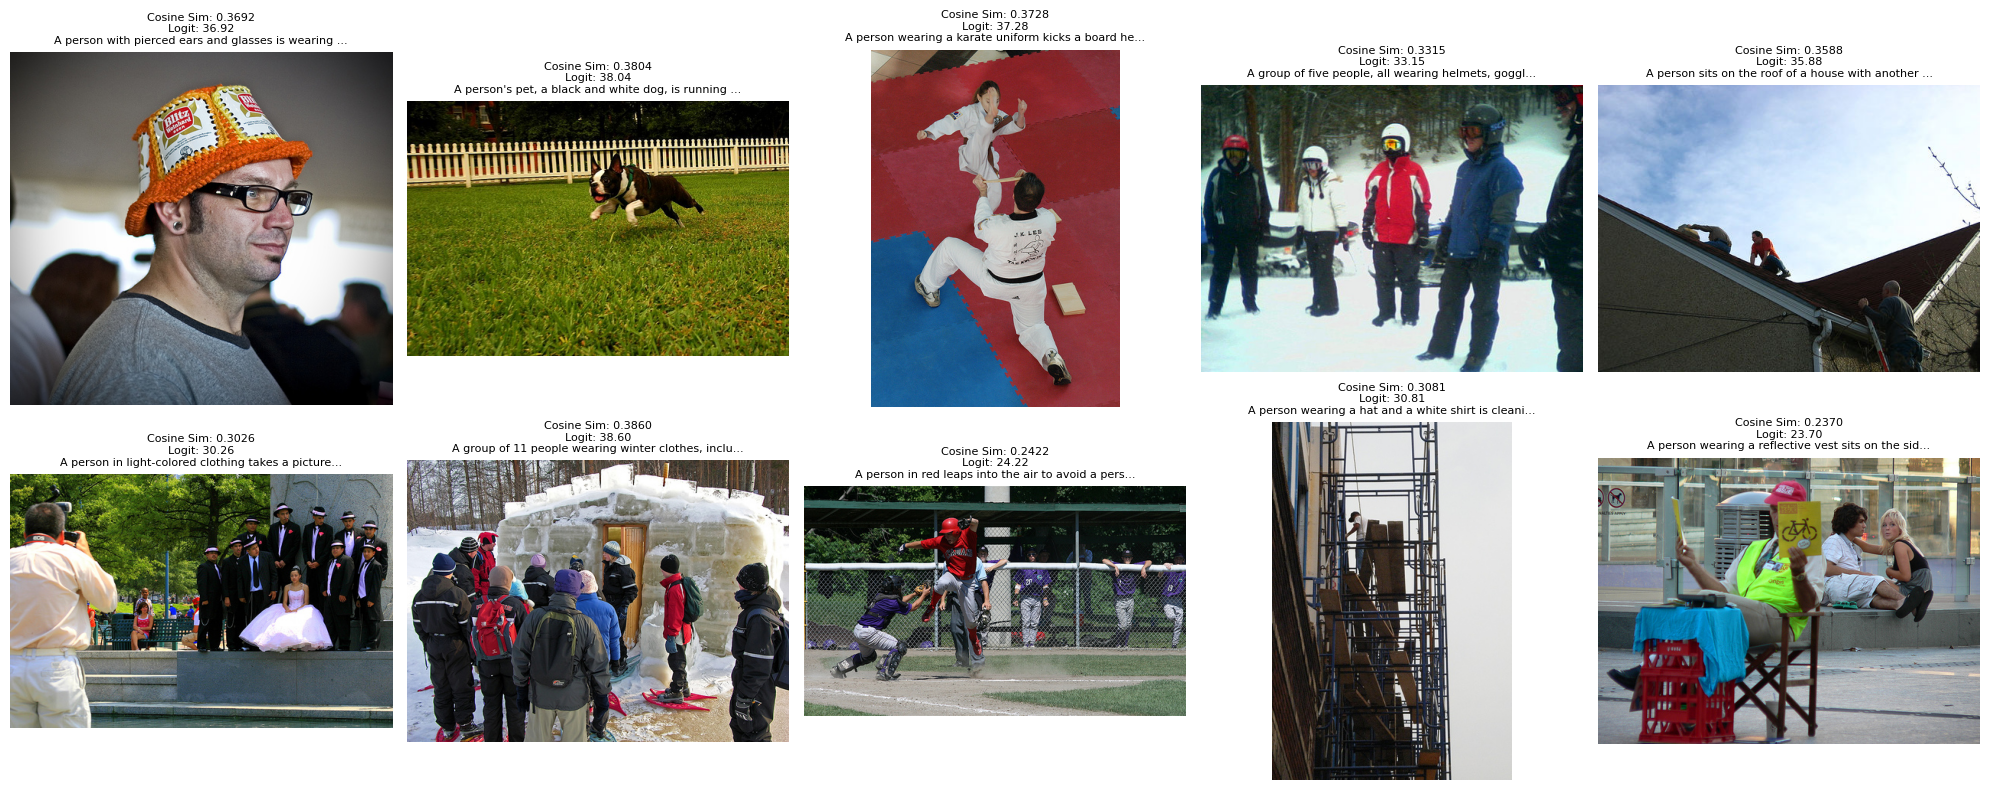


Similarity Statistics:
Mean cosine similarity: 0.3289
Std cosine similarity: 0.0524
Mean logit score: 32.8868
Std logit score: 5.2404

Results saved and visualization complete!


In [18]:
import torch
from transformers import CLIPProcessor, CLIPModel
from peft import PeftModel
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the fine-tuned model and processor
model_path = "./clip-lora-finetuned-flickr30k"
try:
    base_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    model = PeftModel.from_pretrained(base_model, model_path).to(device)
    processor = CLIPProcessor.from_pretrained(model_path)
    print("Model loaded successfully")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# Load dataset
try:
    dataset = load_dataset("AnyModal/flickr30k", split="test")
    print(f"Dataset loaded with {len(dataset)} samples")
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

# Get first 10 images and their captions
num_samples = 10
images = []
captions = []

for i in range(num_samples):
    try:
        img = dataset[i]["image"]
        if img is not None:
            images.append(img)
            # Get the first caption for each image
            caption = dataset[i]["alt_text"][0] if isinstance(dataset[i]["alt_text"], list) else dataset[i]["alt_text"]
            captions.append(caption)
        else:
            print(f"Warning: Image {i} is None, skipping")
    except Exception as e:
        print(f"Error processing sample {i}: {e}")

print(f"Successfully loaded {len(images)} images with captions")

# Compute individual similarity scores between each image and its caption
def get_individual_similarity_scores(images, captions):
    scores = []
    model.eval()

    for i, (image, caption) in enumerate(zip(images, captions)):
        try:
            # Process single image-caption pair
            inputs = processor(
                images=[image],
                text=[caption],
                return_tensors="pt",
                padding=True,
                truncation=True
            ).to(device)

            with torch.no_grad():
                outputs = model(**inputs)
                # Get image and text embeddings
                image_embeds = outputs.image_embeds
                text_embeds = outputs.text_embeds

                # Normalize embeddings
                image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
                text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)

                # Compute cosine similarity
                similarity = torch.mm(image_embeds, text_embeds.t()).item()
                scores.append(similarity)

        except Exception as e:
            print(f"Error processing pair {i}: {e}")
            scores.append(0.0)

    return scores

# Alternative method using logits (if you prefer the original approach)
def get_similarity_scores_logits(images, captions):
    scores = []
    model.eval()

    try:
        inputs = processor(
            images=images,
            text=captions,
            return_tensors="pt",
            padding=True,
            truncation=True
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            logits_per_image = outputs.logits_per_image

            # Get diagonal elements (each image with its corresponding caption)
            diagonal_scores = torch.diag(logits_per_image).cpu().numpy().tolist()
            scores = diagonal_scores

    except Exception as e:
        print(f"Error computing logits: {e}")
        scores = [0.0] * len(images)

    return scores

# Compute similarity scores using both methods
print("Computing similarity scores...")
similarity_scores = get_individual_similarity_scores(images, captions)
logit_scores = get_similarity_scores_logits(images, captions)

print(f"Similarity scores (cosine): {similarity_scores}")
print(f"Logit scores: {logit_scores}")

# Visualize results
if len(images) > 0:
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()

    for idx in range(len(images)):
        if idx < len(axes):
            ax = axes[idx]

            # Convert PIL image to numpy array for display
            img_array = np.array(images[idx])
            ax.imshow(img_array)

            # Truncate caption if too long
            caption_display = captions[idx][:50] + "..." if len(captions[idx]) > 50 else captions[idx]

            ax.set_title(
                f"Cosine Sim: {similarity_scores[idx]:.4f}\n"
                f"Logit: {logit_scores[idx]:.2f}\n"
                f"{caption_display}",
                fontsize=8
            )
            ax.axis("off")

    # Hide empty subplots
    for idx in range(len(images), len(axes)):
        axes[idx].axis("off")

    plt.tight_layout()
    plt.savefig("similarity_results.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Print statistics
    print(f"\nSimilarity Statistics:")
    print(f"Mean cosine similarity: {np.mean(similarity_scores):.4f}")
    print(f"Std cosine similarity: {np.std(similarity_scores):.4f}")
    print(f"Mean logit score: {np.mean(logit_scores):.4f}")
    print(f"Std logit score: {np.std(logit_scores):.4f}")

else:
    print("No images to display")

# Optional: Save results to file
results = {
    'captions': captions,
    'cosine_similarities': similarity_scores,
    'logit_scores': logit_scores
}

print("\nResults saved and visualization complete!")

## Similarity Results Visualization

<p align="center">
  <img src="similarity_results.png" alt="Similarity Scores Visualization" width="900"/>
</p>

# Saving results and model

In [19]:
# Quick script to save and zip everything
# Run this after your training is complete

import zipfile
import os
import shutil
from datetime import datetime

# Ensure model is saved (add this right after your training)
print("Saving model and processor...")
model.save_pretrained("./clip-lora-finetuned-flickr30k")
processor.save_pretrained("./clip-lora-finetuned-flickr30k")
print("✓ Model and processor saved")

# Create zip file
print("\nCreating zip file...")
zip_filename = "/content/clip_lora_complete_results.zip"

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:

    # Add model directory
    model_path = "/content/clip-lora-finetuned-flickr30k"
    if os.path.exists(model_path):
        for root, dirs, files in os.walk(model_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, "/content/")
                zipf.write(file_path, arcname)
                print(f"Added: {arcname}")

    # Add similarity results image
    image_path = "/content/similarity_results.png"
    if os.path.exists(image_path):
        zipf.write(image_path, "similarity_results.png")
        print("Added: similarity_results.png")

print(f"✓ Zip created: {zip_filename}")

# Get file size
size_mb = os.path.getsize(zip_filename) / (1024 * 1024)
print(f"✓ File size: {size_mb:.2f} MB")

# Save to Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    drive_path = f'/content/drive/MyDrive/clip_lora_results_{timestamp}.zip'
    shutil.copy2(zip_filename, drive_path)
    print(f"✓ Saved to Google Drive: {drive_path}")

except Exception as e:
    print(f"Google Drive save failed: {e}")

# Download file
try:
    from google.colab import files
    files.download(zip_filename)
    print("✓ Download initiated")
except Exception as e:
    print(f"Download failed: {e}")

print("\n=== All done! ===")

Saving model and processor...
✓ Model and processor saved

Creating zip file...
Added: clip-lora-finetuned-flickr30k/vocab.json
Added: clip-lora-finetuned-flickr30k/adapter_config.json
Added: clip-lora-finetuned-flickr30k/merges.txt
Added: clip-lora-finetuned-flickr30k/README.md
Added: clip-lora-finetuned-flickr30k/special_tokens_map.json
Added: clip-lora-finetuned-flickr30k/adapter_model.safetensors
Added: clip-lora-finetuned-flickr30k/tokenizer.json
Added: clip-lora-finetuned-flickr30k/tokenizer_config.json
Added: clip-lora-finetuned-flickr30k/preprocessor_config.json
Added: clip-lora-finetuned-flickr30k/checkpoint-2500/adapter_config.json
Added: clip-lora-finetuned-flickr30k/checkpoint-2500/rng_state.pth
Added: clip-lora-finetuned-flickr30k/checkpoint-2500/README.md
Added: clip-lora-finetuned-flickr30k/checkpoint-2500/trainer_state.json
Added: clip-lora-finetuned-flickr30k/checkpoint-2500/adapter_model.safetensors
Added: clip-lora-finetuned-flickr30k/checkpoint-2500/scheduler.pt
Add

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Download initiated

=== All done! ===
